## Импортируем необходимые библиотеки:

In [1]:
import os.path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalMaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Nadam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import mean_absolute_error

## Проанализируем данные

In [2]:
# файл с метриками
labels_path = '/Users/darya.dyurdeva/Documents/dataset/labels.csv'

# директория с картинками
faces_path = '/Users/darya.dyurdeva/Documents/dataset/final_files/final_files'

In [3]:
# загружаем метрики в датафрейм
df = pd.read_csv(labels_path)

#оценим содержимое 
display(df.head())

#общая информация о данных
df.info()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
#характеристики
df.describe(include= 'all')

,file_name,real_age
count,7591,7591.000000
unique,7591,NaN
top,000000.jpg,NaN
freq,1,NaN
mean,NaN,31.201159
std,NaN,17.145060
min,NaN,1.000000
25%,NaN,20.000000
50%,NaN,29.000000
75%,NaN,41.000000


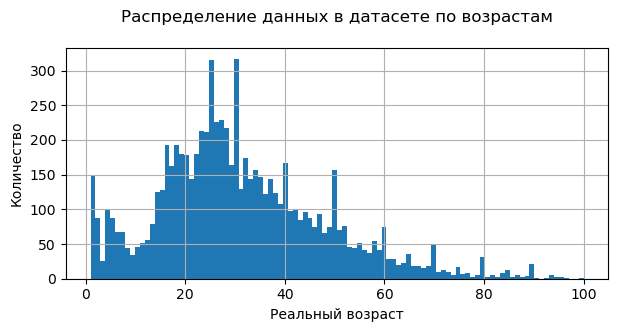

In [5]:
#график распредления возраста 
plt.figure(figsize=(7,3))
plt.title('Распределение данных в датасете по возрастам\n')
plt.xlabel('Реальный возраст')
plt.ylabel('Количество')
df.real_age.hist(bins=100);

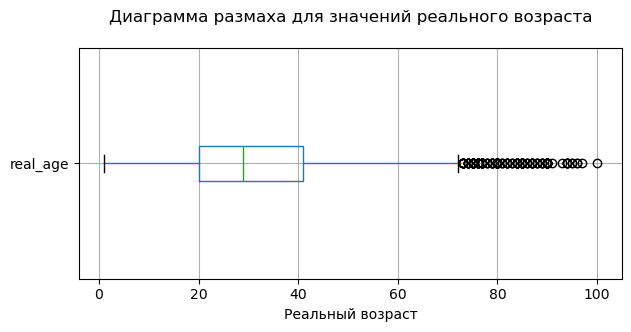

In [6]:
# оценим выбросы
plt.figure(figsize=(7,3))
plt.title('Диаграмма размаха для значений реального возраста\n')
plt.xlabel('Реальный возраст')
df.boxplot('real_age', vert=False);

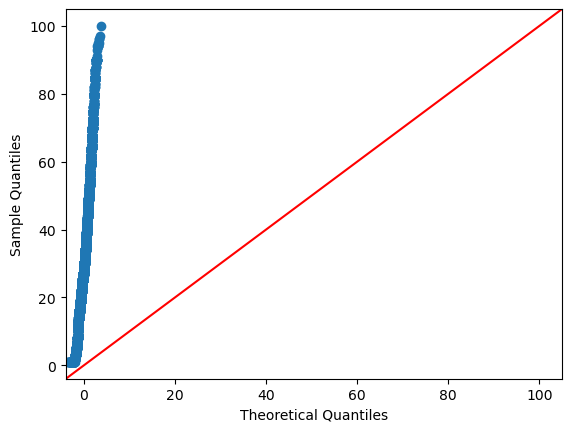

In [7]:
#График Q-Q для визуальной оценки того, насколько близко распределение данных к нормальному распределению. 
fig = sm.qqplot(df.real_age, line='45')
plt.show()

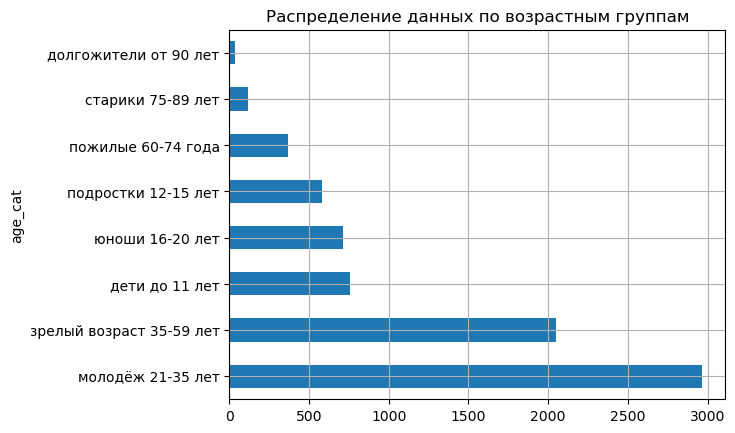

In [8]:
# возрастные группы
df['age_cat'] = pd.cut(
    df.real_age,
    bins=[0, 11, 16, 20, 35, 59, 74, 89, 100],
    labels=['дети до 11 лет', 'подростки 12-15 лет', 'юноши 16-20 лет',
            'молодёж 21-35 лет', 'зрелый возраст 35-59 лет',
            'пожилые 60-74 года', 'старики 75-89 лет',
            'долгожители от 90 лет']
)
df.age_cat.value_counts().plot(
    kind='barh', grid=True,
    title='Распределение данных по возрастным группам'
);

In [9]:
# проверим наличие всех файлов соотвествующих записям
lost_files = []
for i in df.index:
    file_name = df.iloc[i]['file_name']
    if not os.path.exists(os.path.join(faces_path, file_name)):
        lost_files.append([i, file_name])
# потерянные файлы
lost_files

[]

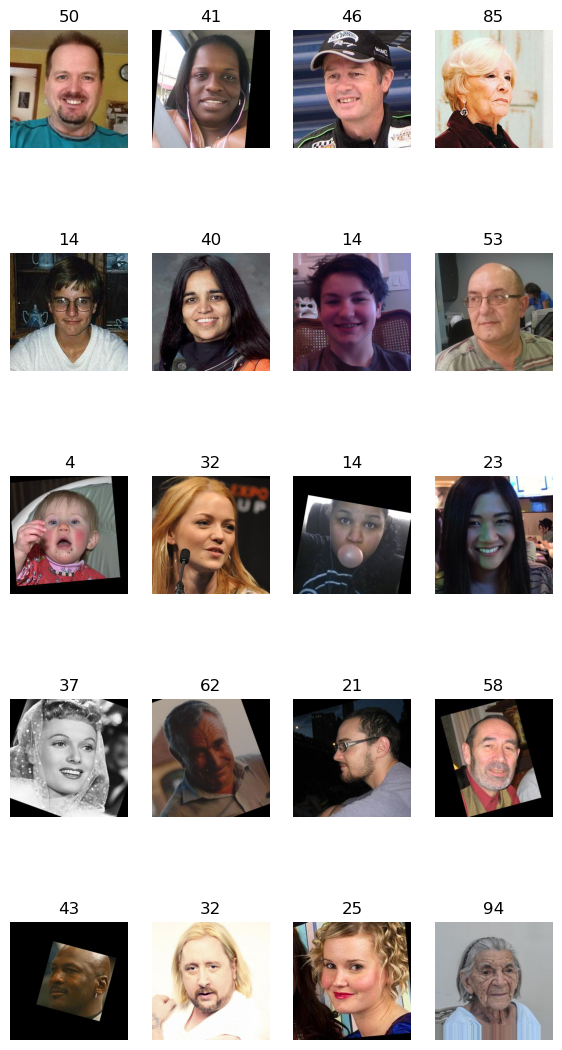

In [10]:
# посмотрим на изображения
# число строк и колонок
rows = 5
columns = 4

# выборка произвольных данных
images = df.sample(rows*columns, random_state=12345)

# выведем изображения и данные возраста
fig = plt.figure(figsize=(7, 14))
for i in range(columns*rows):
    img = Image.open(os.path.join(faces_path, images.iloc[i]['file_name']))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(images.iloc[i]['real_age'])
plt.show()

## Выводы

1) Мы загрузили и провели исследование набора данных. Набор состоит из двух частей, это папка с фотографиями людей и файл в формате csv, который содержит имена файлов и возраст человека на фото.
2) Датафрейм содержит 7951 запись
3) Пропусков данных нет.
4) Дублей нет.
5) Информация о возрасте имеет следующие характеристики: минимальный возраст 1 год, максимальный - 100 лет, средний возраст 31 год, медианный - 29 лет. Визуально, возраст людей на фотографиях, соотвествует указанному возрасту в датасете.
6) Распределение объектов по возрасту не равномерное и напоминает по форме распределение Пуассона и похоже на распределение возраста в естественной популяции, со средним значением 31.2 и стандартным отклонением 17.14, при этом 95% значений лежат в диапазоне до 2 лет до 71 года. Наибольшее число данных приходится на диапазон возрастов от 20 до 59 лет. Меньше всего фотографий людей от 60 лет и старше поэтому можно предположить что значения ошибки на изображениях лиц пожилых людей будет больше.

Таким образом мы имеем достаточно не большой и разбалансированный набор данных и это может негативным образом отразится на обучении модели и качестве её работы.  Для снижения дисбаланса можно использовать технику аугментации изображений редко представленных возрастных групп.

## Обучение модели

Определяя возраст человека по его фото, мы называем некоторое число из небольшого дипазона. Для решения этой задачи нам подойдёт модель, которая будет решать задачу регрессии.

С изображениями лучше всего работают нейронные сети. Мы воспользуемся готовой архитектурой сверточной нейронной сети ResNet50 предобученной на датасете ImageNet. Это позволит уменьшить время обучения и сэкономить вычислительные ресурсы.

У ResNet нам необходимо переделать выходные полносвязные слои для решения задачи регресси. На выходе сети у нас будет всего один нейрон с функцией активации ReLU. Положительные прогнозы сети функция ReLU не меняет, а все отрицательные — приводит к нулю. Возраст меньше 0 быть не может.

В качестве фунции потерь будем использовать Mean Squared Error, она позволяет модели обучаться быстрее.

Для оценки качества модели используем Mean Absolute Error. По условию задачи её значение на тестовой выборке не должно превышать 8.

In [11]:
# генератор тренировочной выборки
def load_train(path):
    dataframe = pd.read_csv(path + '/labels.csv')
    train_datagen = ImageDataGenerator(
        rescale=1.0/255, validation_split=0.25,
        horizontal_flip=True
    )
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe,
        directory=path + '/final_files/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=12345,
        subset='training'
    )
    return train_datagen_flow

# генератор тестовой выборки
def load_test(path):
    dataframe = pd.read_csv(path + '/labels.csv')
    test_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe,
        directory=path + '/final_files/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        shuffle=True,
        seed=12345,
        subset='validation'
    )
    return test_datagen_flow

# создаём модель
def create_model(input_shape):
    optimizer = tf.keras.optimizers.legacy.Nadam(learning_rate=0.0002)
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    model = Sequential()
    model.add(backbone)
    model.add(GlobalMaxPool2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# обучаем модель
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
    path_model = '/Users/darya.dyurdeva/Documents/model_1'
    #сохрание в файл модели 
    save_best_model = ModelCheckpoint(filepath=path_model, 
                                  monitor='val_loss', 
                                  save_best_only=True, 
                                  save_weights_only=False, 
                                  mode='min')
    csv_logger = CSVLogger('training_history.csv')
    # условие оставновки по уровню ошибки
    stop_loss = EarlyStopping(
        monitor='val_loss', patience=5,
        verbose=1, restore_best_weights=True
    )
    # условие оставновки по метрике качества
    stop_mae = EarlyStopping(
        monitor='val_mae', patience=5,
        verbose=1, restore_best_weights=True
    )
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size, epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[stop_loss, stop_mae, save_best_model, csv_logger],
        verbose=1
    )
    return model

In [12]:
# создадим выборки
path = '/Users/darya.dyurdeva/Documents/dataset/'

train_data = load_train(path)
test_data = load_test(path)
# создадим модель
model = create_model(input_shape = (224, 224, 3))

#сохраним модель: 
history = train_model(
    model, train_data, test_data, batch_size=None, epochs=15,
    steps_per_epoch=None, validation_steps=None
)

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Epoch 1/15


2024-03-25 20:50:22.589682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-25 20:50:22.593723: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


178/178 [==============================] - ETA: 0s - loss: 163.0822 - mae: 9.6506

2024-03-25 20:58:52.626987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


178/178 [==============================] - 558s 3s/step - loss: 163.0822 - mae: 9.6506 - val_loss: 732.6157 - val_mae: 22.1470
Epoch 2/15
178/178 [==============================] - ETA: 0s - loss: 81.3039 - mae: 6.9101

INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


178/178 [==============================] - 554s 3s/step - loss: 81.3039 - mae: 6.9101 - val_loss: 678.3834 - val_mae: 20.9918
Epoch 3/15
178/178 [==============================] - ETA: 0s - loss: 52.2067 - mae: 5.4883

INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


178/178 [==============================] - 542s 3s/step - loss: 52.2067 - mae: 5.4883 - val_loss: 385.3241 - val_mae: 14.6412
Epoch 4/15
178/178 [==============================] - ETA: 0s - loss: 36.8785 - mae: 4.6761

INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


178/178 [==============================] - 537s 3s/step - loss: 36.8785 - mae: 4.6761 - val_loss: 140.5804 - val_mae: 8.7719
Epoch 5/15
178/178 [==============================] - ETA: 0s - loss: 30.2091 - mae: 4.2091

INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


178/178 [==============================] - 542s 3s/step - loss: 30.2091 - mae: 4.2091 - val_loss: 101.8078 - val_mae: 7.5607
Epoch 6/15
178/178 [==============================] - ETA: 0s - loss: 26.3918 - mae: 3.9142

INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


178/178 [==============================] - 545s 3s/step - loss: 26.3918 - mae: 3.9142 - val_loss: 74.4586 - val_mae: 6.4281
Epoch 7/15
178/178 [==============================] - 534s 3s/step - loss: 24.0852 - mae: 3.7524 - val_loss: 78.6327 - val_mae: 6.6509
Epoch 8/15
178/178 [==============================] - ETA: 0s - loss: 21.0584 - mae: 3.4784

INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


178/178 [==============================] - 539s 3s/step - loss: 21.0584 - mae: 3.4784 - val_loss: 73.5739 - val_mae: 6.2696
Epoch 9/15
178/178 [==============================] - ETA: 0s - loss: 19.9020 - mae: 3.3883

INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


178/178 [==============================] - 539s 3s/step - loss: 19.9020 - mae: 3.3883 - val_loss: 70.8710 - val_mae: 6.1829
Epoch 10/15
178/178 [==============================] - 532s 3s/step - loss: 17.5928 - mae: 3.1730 - val_loss: 72.0309 - val_mae: 6.5144
Epoch 11/15
178/178 [==============================] - 531s 3s/step - loss: 16.3629 - mae: 3.0753 - val_loss: 79.0895 - val_mae: 6.8992
Epoch 12/15
178/178 [==============================] - 510s 3s/step - loss: 15.6603 - mae: 3.0111 - val_loss: 98.2516 - val_mae: 7.3347
Epoch 13/15
178/178 [==============================] - ETA: 0s - loss: 14.7789 - mae: 2.9179

INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


INFO:tensorflow:Assets written to: /Users/darya.dyurdeva/Documents/model_1/assets


178/178 [==============================] - 541s 3s/step - loss: 14.7789 - mae: 2.9179 - val_loss: 62.9841 - val_mae: 5.8054
Epoch 14/15
178/178 [==============================] - 527s 3s/step - loss: 13.7757 - mae: 2.8239 - val_loss: 68.2491 - val_mae: 6.1688
Epoch 15/15
178/178 [==============================] - 537s 3s/step - loss: 13.1642 - mae: 2.7640 - val_loss: 63.3932 - val_mae: 5.8820


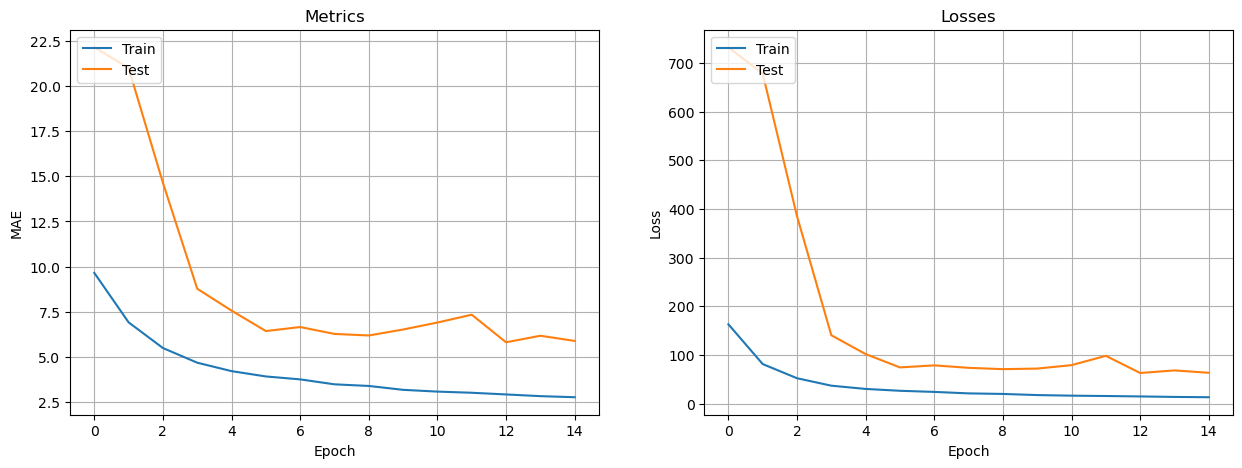

In [13]:

# построим графики пороцесса обучения
plt.figure(figsize=(15,5))
# метрики модели
plt.subplot(1, 2, 1)
plt.plot(history.history.history['mae'])
plt.plot(history.history.history['val_mae'])
plt.grid(True)
plt.title('Metrics')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# ошибки модели
plt.subplot(1, 2, 2)
plt.plot(history.history.history['loss'])
plt.plot(history.history.history['val_loss'])
plt.grid(True)
plt.title('Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Анализ обученной модели

In [28]:
# следующий батч тестовой выборки
features_test, target_test = next(test_data) 
model = tf.keras.models.load_model('/Users/darya.dyurdeva/Documents/model_1')
# предсказание модели на данных батча
predicted = model.predict(features_test)

# расчитаем МАЕ
mae = mean_absolute_error(target_test, predicted[:,0])

print(f'\nЗначение MAE на батче из тестовой выборки: {mae.numpy():.3f}')

1/1 [==============================] - 1s 1s/step

Значение MAE на батче из тестовой выборки: 6.180


In [21]:
# сравним реальный и предсказанный возраст
results = pd.DataFrame(target_test, columns=['Реальный возраст'])

results['Предсказаный возраст'] = pd.DataFrame(
    round(pd.DataFrame(predicted, columns=['Предсказаный возраст'])).astype('int')
)
results['Размер ошибки'] = results['Реальный возраст'] - results['Предсказаный возраст']

results

,Реальный возраст,Предсказаный возраст,Размер ошибки
0,58,58,0
1,40,31,9
2,25,26,-1
3,45,40,5
4,5,15,-10
5,31,28,3
6,19,20,-1
7,40,50,-10
8,26,27,-1
9,58,52,6


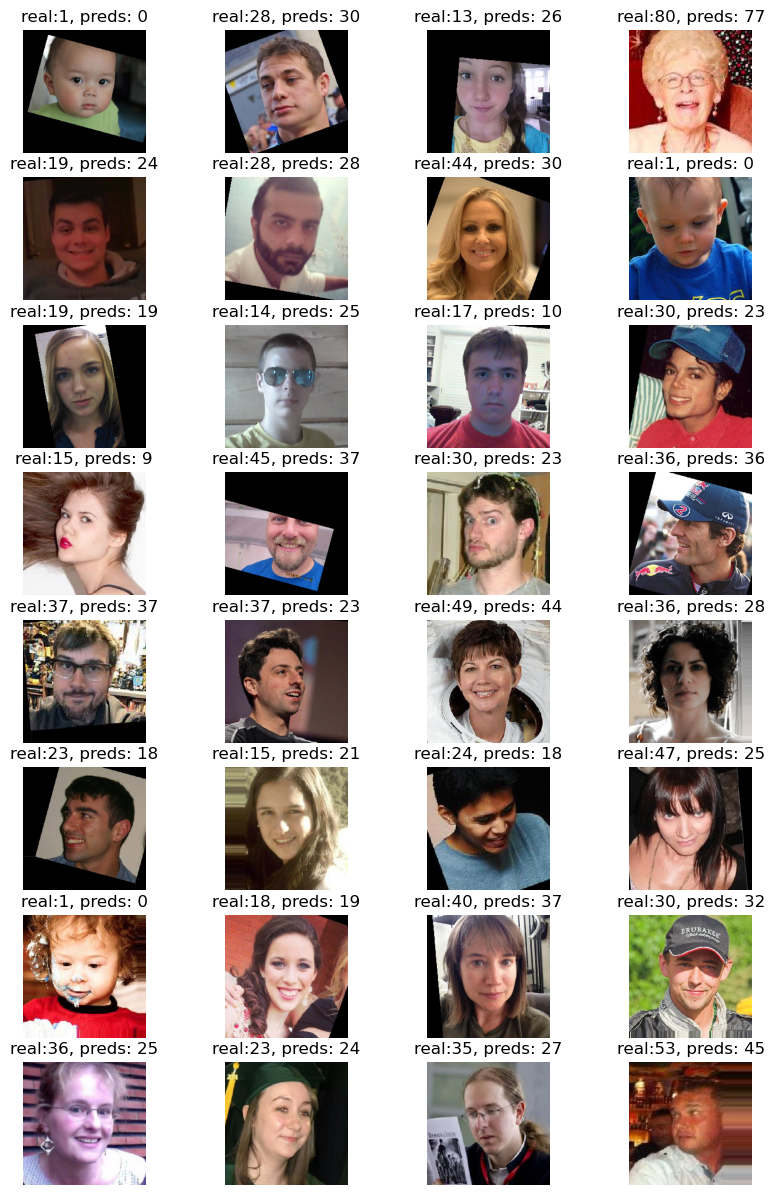

In [23]:
# выведем изображения и предсказанный возраст
columns = 4
rows = len(predicted) // columns
fig = plt.figure(figsize=(10,15))
for i in range(len(predicted)):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(features_test[i])
    plt.axis('off')
    plt.title(f'real:{target_test[i]}, preds: {round(predicted[i][0])}')
plt.show()

In [22]:
# средний МАЕ на подвыборках тестовых данных
mae = []
for i in range(len(test_data)):
    features_test, target_test = next(test_data)
    predicted = model.predict(features_test)
    mae.append((mean_absolute_error(target_test, predicted[:,0])).numpy())
print('\nСреднее значение на подвыборках тестовых данных:', sum(mae) / len(mae))

1/1 [==============================] - 1s 642ms/step

Среднее значение на подвыборках тестовых данных: 5.84356110493342


##### Вывод

Мы обучили модель и проверили её работу на тестовой выборке. Значение метрики MAE составило 5.84, что можно считать приемлемым результатом.

Но видим, что модель может достаточно сильно ошибаться как в большую так и в меньшую сторону. Особенно такие ошибки заметны на детях, т.е. при небольших значениях возраста ошибка в 6 лет становится существенной, в то время как для людей зрелого возраста и старше подобные ошибки можно считать не значительными.